In [1]:
import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (5, 4)
import matplotlib as mpl
mpl.rcParams['path.simplify'] = False       # prevents clipping masks on lines
mpl.rcParams['agg.path.chunksize'] = 0      # avoids chunked paths (creates clip paths)
mpl.rcParams['figure.facecolor'] = 'white'  # avoids transparency-related clipping
mpl.rcParams['savefig.transparent'] = False # keep backgrounds opaque
mpl.rcParams['savefig.bbox'] = 'tight'      # clean bbox without extra masks
import os 

#### AR simulations 


In [ ]:
# T = 100 # number of timepoints
# w_real = np.array([0.01])

zs = lambda v: (v-v.mean(0))/v.std(0)

# def make_arp(w_real, T):
#     p = len(w_real)
#     add_noise = np.random.randn(T) # noise at each timepoint
#     signal = np.zeros(T)
#     signal[:p] = add_noise[:p]
#     w = w_real[::-1]

#     for t in range(p, T):
#         signal[t] = np.dot(w, signal[t-p:t]) + add_noise[t]
#     return signal

# def make_arp_vec(w_real, n, T):
#     return np.vstack([make_arp(w_real, T) for _ in range(n)]).T

# def make_noisy_arp(ar_coeff, nT, n_series, noise_std=1, measurement_noise_std=1):
    
#     ar_noise = np.random.randn(n_series, nT) * noise_std
    
#     # Generate measurement noise that is NOT part of the AR process (white or pink)
#     white_noise = np.random.randn(n_series,nT) * measurement_noise_std
#     # pink_noise = np.array([make_pink_noise(nT) for _ in range(n_series)]) * measurement_noise_std

#     time_series = np.zeros((n_series, nT))
#     time_series[:,0] = ar_noise[:,0]

#     for t in range(1, nT):
#         time_series[:, t] = ar_coeff * time_series[:, t - 1] + ar_noise[:,t]


#     noisy_time_series = time_series + white_noise
#     # noisy_time_series = time_series + pink_noise
    
#     return white_noise, time_series, noisy_time_series #(n_series, nT)


def make_pink_noise(nT, beta=1):
    # beta: power law exponent
    freqs = np.fft.rfftfreq(nT)
    freqs[0] = 1
    spectrum = np.random.randn(len(freqs)) + 1j * np.random.randn(len(freqs))
    spectrum /= freqs ** (beta/2)  # power spectrum follos 1/f^beta, amplitude spectrum follows this
    pink_noise = np.fft.irfft(spectrum, n=nT)
    return pink_noise / np.std(pink_noise)

# simulating AR processes with added noise
# def make_correlated_arp(ar_coeff, nT, n_voxs, corr, noise_std=1, measurement_noise_std=0.5):
#     shared_noise_std = noise_std * np.sqrt(corr)  # shared variability across voxels
#     unique_noise_std = noise_std * np.sqrt(1 - corr) # independent variability
    
#     shared_noise = np.random.randn(nT) * shared_noise_std
#     unique_noise = np.random.randn(n_voxs, nT) * unique_noise_std 

#     # Generate measurement noise that is NOT part of the AR process (white or pink)
#     white_noise = np.random.randn(n_voxs, nT) * measurement_noise_std
#     # pink_noise = np.array([make_pink_noise(nT) for _ in range(n_series)]) * measurement_noise_std

#     ar_noise = shared_noise[None,:] + unique_noise

#     time_series = np.zeros((n_voxs, nT))
#     time_series[:,0] = ar_noise[:,0]

#     for t in range(1, nT):
#         time_series[:, t] = ar_coeff * time_series[:, t - 1] + ar_noise[:,t]


#     noisy_time_series = time_series + white_noise
#     # noisy_time_series = time_series + pink_noise
    
    return noisy_time_series #(n_series, nT)

# def make_correlated_arp(ar_coeff, nT, n_voxs, corr, private_signal_std, shared_signal_std, measurement_noise_std=0.5):
#     shared_signal = np.random.randn(nT) * shared_signal_std * np.sqrt(corr)
#     private_signal = np.random.randn(n_voxs, nT) * private_signal_std * np.sqrt(1-corr)

#     # Generate measurement noise that is NOT part of the AR process (white or pink)
#     white_noise = np.random.randn(n_voxs, nT) * measurement_noise_std
#     # pink_noise = np.array([make_pink_noise(nT) for _ in range(n_series)]) * measurement_noise_std

#     ar_noise = shared_signal[None,:] + private_signal

#     time_series = np.zeros((n_voxs, nT))
#     time_series[:,0] = ar_noise[:,0]

#     for t in range(1, nT):
#         time_series[:, t] = ar_coeff * time_series[:, t - 1] + ar_noise[:,t]


#     noisy_time_series = time_series + white_noise
#     # noisy_time_series = time_series + pink_noise
    
#     return noisy_time_series #(n_series, nT)

# def make_correlated_arp(ar_coeff, nT, n_voxs, uniq_noise_std=1.0, shared_noise_std=0.5, measurement_noise_std=0.5):
#     """
#     - each voxel has the same unique innovation std (uniq_noise_std)
#     - all voxels share an additional common innovation term with std (shared_noise_std)
#     - measurement noise is added on top, and does not go into the AR process

#     Returns:
#         noisy_time_series: array of shape (n_voxs, nT)
#     """
    
#     shared_noise = np.random.randn(nT) * shared_noise_std
#     unique_noise = np.random.randn(n_voxs, nT) * uniq_noise_std 

#     # Generate measurement noise that is NOT part of the AR process (white or pink)
#     white_noise = np.random.randn(nT) * measurement_noise_std
#     # pink_noise = np.array([make_pink_noise(nT) for _ in range(n_series)]) * measurement_noise_std

#     ar_noise = shared_noise[None,:] + unique_noise

#     time_series = np.zeros((n_voxs, nT))
#     time_series[:,0] = ar_noise[:,0]

#     for t in range(1, nT):
#         time_series[:, t] = ar_coeff * time_series[:, t - 1] + ar_noise[:,t]


#     noisy_time_series = time_series + white_noise
#     # noisy_time_series = time_series + pink_noise
    
#     return noisy_time_series #(n_voxs, nT)

# # simulating noise-less AR processes
# def make_noiseless_arp(ar_coeff, nT, n_voxs, noise_std=1):
#     noise = np.random.randn(n_voxs, nT) * noise_std
#     time_series = np.zeros((n_voxs, nT))
#     time_series[:,0] = noise[:,0]
#     for t in range(1, nT):
#         time_series[:, t] = ar_coeff * time_series[:, t - 1] + noise[:,t]
        
#     return time_series, noise #(n_voxs, nT)



def make_signal_innov(n_voxs, nT, private_signal_std, corr, beta=0.5):
    """
    n_voxs, nT:    number of voxels and time points
    private_signal_std: signal innovation std (should be the total std)
    corr:          fraction of innovation variance that is shared across voxels
    beta:          fraction of shared variance going to shared_signal_inno
                   (rest 1-beta goes to shared_noise)
    Returns
    -------
    private_signal_innov  : (n_voxs, nT)
    shared_signal_innov    : (nT,)
    shared_noise_innov     : (nT,)
    """

    sigma = private_signal_std  # just renaming

    # Variance allocations
    var_private        = (1.0 - corr) * sigma**2
    var_shared_signal  = corr * beta * sigma**2
    var_shared_noise   = corr * (1.0 - beta) * sigma**2

    # Corresponding stds
    std_private        = np.sqrt(var_private)
    std_shared_signal  = np.sqrt(var_shared_signal)
    std_shared_noise   = np.sqrt(var_shared_noise)

    # Draw components
    private_signal_innov      = np.random.randn(n_voxs, nT) * std_private          # voxel-specific
    shared_signal_innov = np.random.randn(nT) * std_shared_signal           # shared across voxels & runs
    shared_noise_innov       = np.random.randn(nT) * std_shared_noise            # shared across voxels, per run

    return private_signal_innov, shared_signal_innov, shared_noise_innov

# simulating noise-less AR processes
def make_noiseless_arp(ar_coeff, nT, n_voxs, private_signal_innov):
    time_series = np.zeros((n_voxs, nT))
    time_series[:,0] = private_signal_innov[:,0]
    for t in range(1, nT):
        time_series[:, t] = ar_coeff * time_series[:, t - 1] + private_signal_innov[:,t]
        
    return time_series #(n_voxs, nT)

def make_additive_noisy_arp(ar_coeff, nT, n_voxs, signal_innov, measurement_noise_std):
    white_noise = np.random.randn(n_voxs, nT) * measurement_noise_std

    time_series = np.zeros((n_voxs, nT))
    time_series[:,0] = signal_innov[:,0]

    for t in range(1, nT):
        time_series[:, t] = ar_coeff * time_series[:, t - 1] + signal_innov[:,t]


    noisy_time_series = time_series + white_noise

    return noisy_time_series

# def curvature(X):
#     V = X[1:] - X[:-1]
#     norms = np.sqrt((V**2).sum(1))
#     dots = (V[1:] * V[:-1]).sum(1)
#     coss = dots / (norms[1:] * norms[:-1])
#     #print(coss)
#     angles = np.arccos(coss)
#     return angles.mean()


def avg_pop_curvature(X):
    # X: (n_voxs, nT)
    V = X[:, 1:] - X[:, :-1] #(n_series, nT-1)
    norms = np.linalg.norm(V, axis=0) #(nT-1,)
    dots = (V[:, 1:] * V[:, :-1]).sum(0)
    coss = dots / (norms[1:] * norms[:-1])
    angles = np.degrees(np.arccos(coss))
    return angles.mean()  # return mean curvature across series

In [5]:
os.getcwd()

'/Users/oliviaxujiaming/Library/CloudStorage/GoogleDrive-jiamingx1204@gmail.com/Other computers/My MacBook Pro/Language_straightening/scripts'

##### Fig. 1d schematic - noise corruption illustration

In [3]:
w_real = np.array([0.99])
noise, noiseless, noisy = make_noisy_arp(w_real, 80, 1, noise_std=1, measurement_noise_std=3)
plt.figure(figsize=(5, 6))
plt.plot(noiseless.T, color='black', linewidth=1)
plt.title('Noiseless AR(1) Time Series')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.ylim(-20, 20)
plt.tight_layout()
# plt.savefig("noiseless_ar.pdf", format='pdf', bbox_inches='tight')
plt.close()

# Plot noisy signal
plt.figure(figsize=(5, 6))
plt.plot(noise.T, color='grey', alpha=0.5, linewidth=1)
plt.title('Noisy AR(1) Time Series (with Measurement Noise)')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.ylim(-20, 20)
plt.tight_layout()
# plt.savefig("noise_corrupted_ar.pdf", format='pdf', bbox_inches='tight')
plt.close()

plt.figure(figsize=(5, 6))
plt.plot(noiseless.T, color='black', linewidth=1)
plt.plot(noisy.T, color='grey', alpha=0.5, linewidth=1)
plt.title('Noiseless AR(1) Time Series')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.ylim(-20, 20)
plt.tight_layout()
# plt.savefig("noiseless+noise_ar.pdf", format='pdf', bbox_inches='tight')
# plt.close()
# plt.ylim(-8, 5) 
# plt.savefig("AR(1)_fast.pdf", format='pdf', bbox_inches='tight')

NameError: name 'make_noisy_arp' is not defined

##### Model simulation - example 10d population traj PCA (noiseless and noise-corrupted)

Noiseless 10-D population trajectory

117.49131440332798


(np.float64(-1.6987363213044429),
 np.float64(2.02016597332524),
 np.float64(-1.759623683519585),
 np.float64(1.6889578798594342))

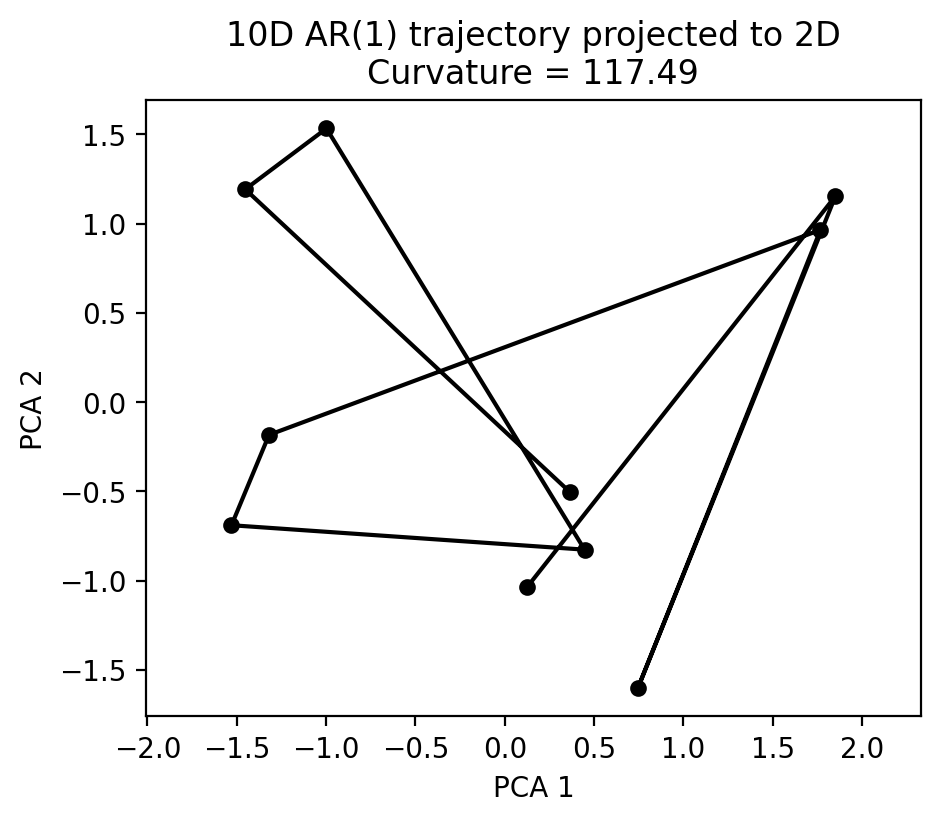

In [102]:
from sklearn.decomposition import PCA
w_real = np.array([0.1])
data = make_arp_vec(w_real, 10, 10)  # shape: (100, 10)
curv = avg_pop_curvature(data.T)
pca = PCA(n_components=2)
noiseless_data_2d = pca.fit_transform(data)  # shape: (100, 2)
print(curv)
plt.plot(noiseless_data_2d[:, 0], noiseless_data_2d[:, 1], '-o', markersize=5, color='black')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title(f"10D AR(1) trajectory projected to 2D\nCurvature = {curv:.2f}")
plt.axis('equal')


Noisy 10-D population trajectory 

(10, 100)
111.45405906932471


(np.float64(-83.2824431158215),
 np.float64(59.10673093408239),
 np.float64(-25.514621062448967),
 np.float64(35.63261798524568))

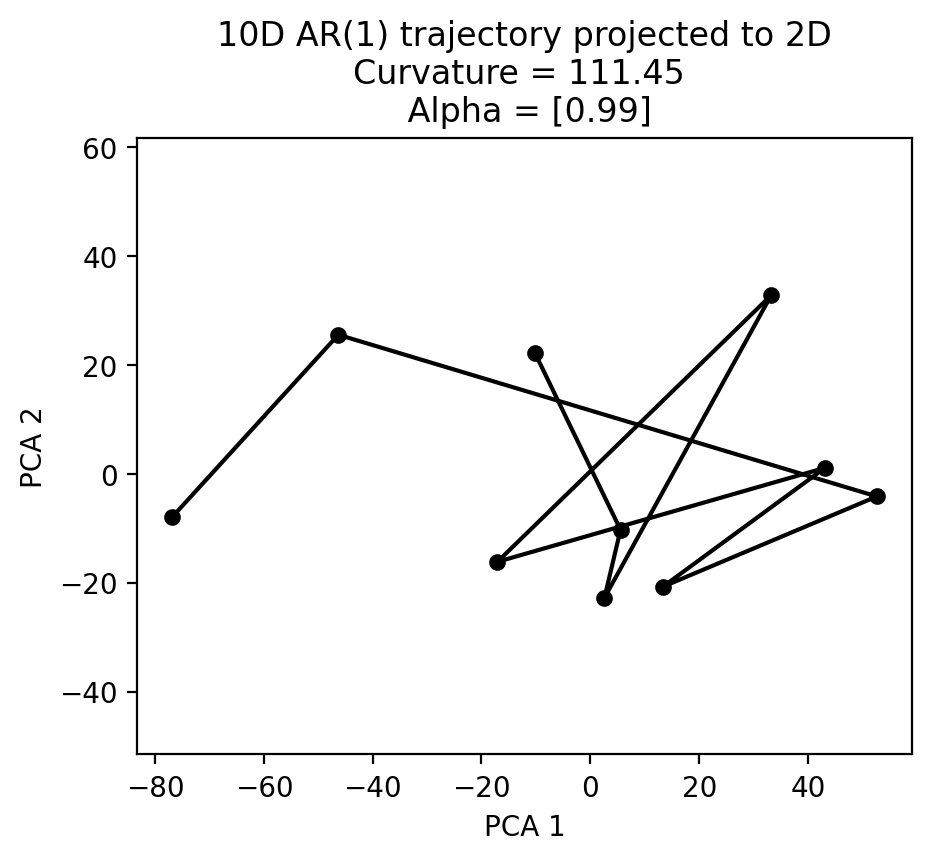

In [ ]:
w_real = np.array([0.99])
data = make_correlated_arp(w_real, nT=100, n_series=10, corr=0, noise_std=1, measurement_noise_std=1)
curv = avg_pop_curvature(data) # need (n_series, nT)
print(data.shape)
print(curv)
pca = PCA(n_components=2)
noisy_data_2d = pca.fit_transform(data)  # shape: (100, 2)

plt.plot(noisy_data_2d[:, 0], noisy_data_2d[:, 1], '-o', markersize=5, color = "black")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title(f"10D AR(1) trajectory projected to 2D\nCurvature = {curv:.2f} \n Alpha = {w_real}")
plt.axis('equal')



Plotting with specific format (pdf)

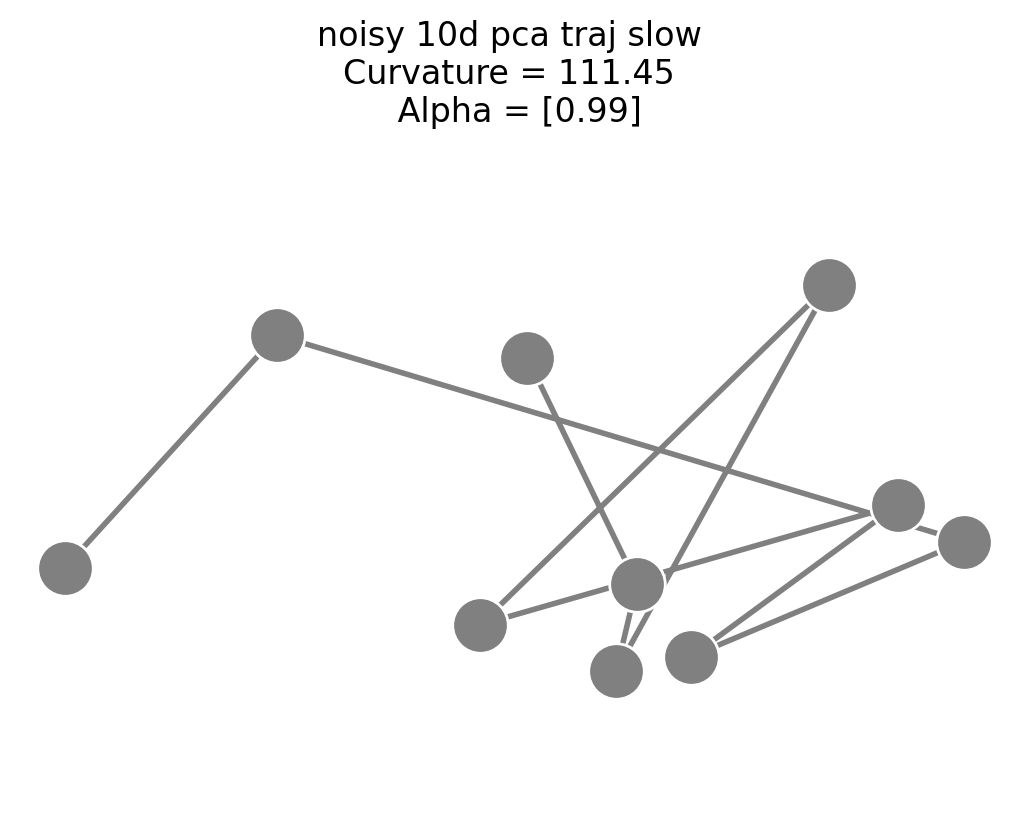

In [ ]:
fig, ax = plt.subplots(figsize=(5, 4))  
# noiseless data
# ax.plot(
#     noiseless_data_2d[:, 0], 
#     noiseless_data_2d[:, 1], 
#     '-o', 
#     markersize=20,                # slightly larger so edge is visible
#     linewidth=2, 
#     markerfacecolor='black',     # fill color
#     markeredgecolor='white',     # outline color
#     markeredgewidth=1,         # optional: control outline thickness
#     color="black"
# )
# noisy data
ax.plot(
    noisy_data_2d[:, 0], 
    noisy_data_2d[:, 1], 
    '-o', 
    markersize=20,                # slightly larger so edge is visible
    linewidth=2, 
    markerfacecolor='grey',     # fill color
    markeredgecolor='white',     # outline color
    markeredgewidth=1,         # optional: control outline thickness
    color="grey"
)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_xlabel("")
ax.set_ylabel("")
plt.title(f"noisy 10d pca traj slow \nCurvature = {curv:.2f} \n Alpha = {w_real}")
ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout(pad=0.2)
# plt.savefig("noisy_10d_pca_traj_slow.pdf", format='pdf', bbox_inches='tight')



##### Fig 2a. Check dimensionality doesn't play a role

In [3]:
# simulate AR(1) processes with different coefficients and see if the relationship preserves
nBoots = 100
nT = 100  
private_signal_std = 0.5
alphas = np.linspace(0, 1, 10)

nD = 10 # dimensionality
all_degs_10d = np.zeros((nBoots, len(alphas)))
for i in range(nBoots):
    for j, a in enumerate(alphas):
        ts,_ = make_noiseless_arp(a, nT=nT, n_voxs=nD, noise_std=private_signal_std)
        deg = avg_pop_curvature(ts)
        all_degs_10d[i, j] = deg
print(all_degs_10d.shape)

nD = 100 # dimensionality
all_degs_100d = np.zeros((nBoots, len(alphas)))
for i in range(nBoots):
    for j, a in enumerate(alphas):
        ts,_ = make_noiseless_arp(a, nT=nT, n_voxs=nD, noise_std=private_signal_std)
        deg = avg_pop_curvature(ts)
        all_degs_100d[i, j] = deg


(100, 10)


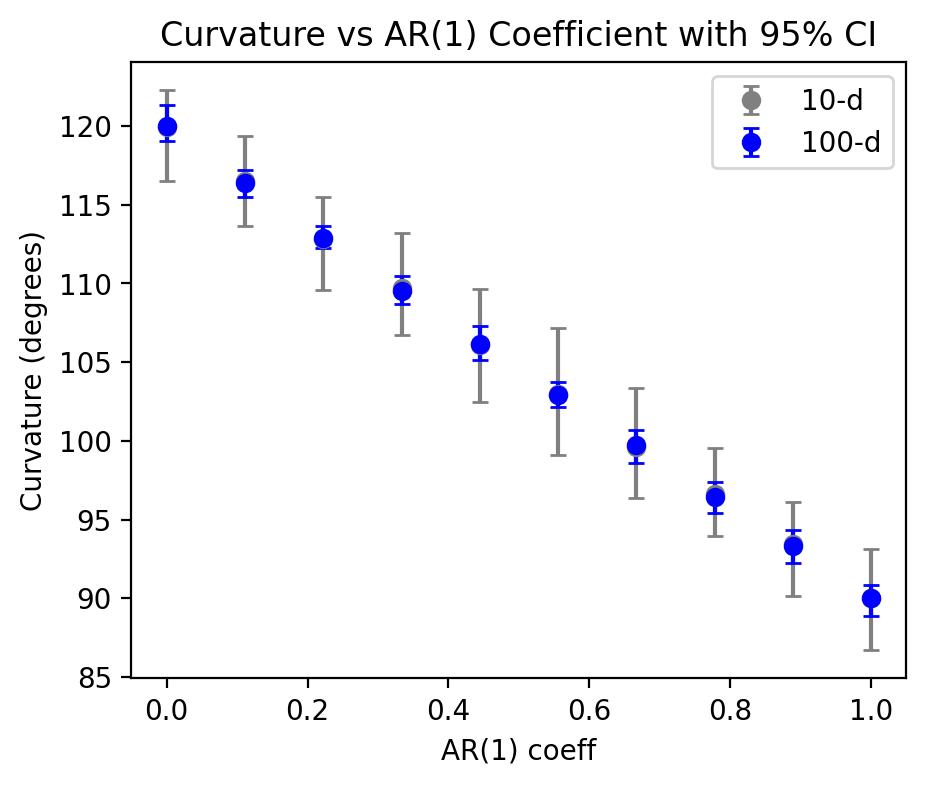

In [4]:
# Compute mean and 95% CI across bootstraps
# 10d
mean_curv_10d = all_degs_10d.mean(axis=0)             # shape: (len(alphas), nT)
lower_10d = np.percentile(all_degs_10d, 2.5, axis=0)   # shape: (len(alphas), nT)
upper_10d = np.percentile(all_degs_10d, 97.5, axis=0)
# 100d
mean_curv_100d = all_degs_100d.mean(axis=0)             # shape: (len(alphas), nT)
lower_100d = np.percentile(all_degs_100d, 2.5, axis=0)   # shape: (len(alphas), nT)
upper_100d = np.percentile(all_degs_100d, 97.5, axis=0)

# Compute error bars: distance from mean to lower/upper CI
yerr_10d = np.vstack([mean_curv_10d - lower_10d, upper_10d - mean_curv_10d])
yerr_100d = np.vstack([mean_curv_100d - lower_100d, upper_100d - mean_curv_100d])

# Plot with error bars
plt.errorbar(alphas, mean_curv_10d, yerr=yerr_10d, fmt='o', capsize=3, color='gray', label='10-d')
plt.errorbar(alphas, mean_curv_100d, yerr=yerr_100d, fmt='o', capsize=3, color='blue', label='100-d')
plt.legend()
plt.xlabel("AR(1) coeff")
plt.ylabel("Curvature (degrees)")
plt.title("Curvature vs AR(1) Coefficient with 95% CI")
plt.savefig("dimensionality-curvature-AR-CI.pdf", format='pdf', bbox_inches='tight')
plt.show()


In [ ]:
# ---- MINI-FIGURE SETTINGS (everything shrunk proportionally) ----
figsize_inches = (1, 1)

marker_size     = 1.5     
marker_edge     = 0.1     
line_width      = 0.4     
font_size       = 4       
alpha_noiseless = 1.0
alpha_low       = 0.6
alpha_high      = 0.3

# ---- Create tiny figure ----
fig, ax = plt.subplots(figsize=figsize_inches, dpi=300)

ax.errorbar(
    alphas, mean_curv_10d,
    yerr=yerr_10d, fmt='o',
    markersize=marker_size,
    markerfacecolor='gray',
    markeredgecolor='white',
    markeredgewidth=marker_edge,
    linewidth=line_width,
    color='gray',
    alpha = 0.6,
    capsize=0.5
)
ax.errorbar(
    alphas, mean_curv_100d,
    yerr=yerr_100d, fmt='o',
    markersize=marker_size,
    markerfacecolor='gray',
    markeredgecolor='white',
    markeredgewidth=marker_edge,
    linewidth=line_width,
    color='blue',
    capsize=0.5
)

ax.tick_params(axis='both',
               which='both',
               labelsize=3,   # font size of tick labels
               length=2,      # length of tick marks
               width=0.5)       # line width of tick marksax.set_xlim(-0.1, 1.1)
# ax.set_aspect('equal', adjustable='datalim')
# ax.axis('square')

# Remove all spines (no box)
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.savefig("dimensionality-curvature-AR-CI-tiny.pdf", format='pdf', bbox_inches='tight')
plt.close()


$$ x_t = \alpha x_{t-1} + \epsilon_t$$

##### Fig 1e. Demonstrate direct curvature measurements are not reliable 

First, simulate 10 independent noise-less AR processes, calculate average population trajectory curvature and fit AR(1) model to estimate coefficient. Simulate with varying coefficients. 

In [6]:
# one run 
ar_coeffs = np.linspace(0.1, 1, 10)
nBoots = 200
nT = 241
n_voxs = 10
private_signal_std = 1.0
shared_signal_std = 1.0
corr = 0.3
measurement_noise_std_low = 0.5
measuremen_noise_std_high = 1

noiseless_timeseries = np.zeros((nBoots, len(ar_coeffs), n_voxs, nT)) #(n_coeffs, n_voxs, nT)
noiseless_est_curv = np.zeros((nBoots, len(ar_coeffs))) # (nBoots, n_coeffs)
noisy_timeseries = np.zeros((nBoots, len(ar_coeffs), n_voxs, nT)) #(n_coeffs, n_voxs, nT)
noisy_est_curv = np.zeros((nBoots, len(ar_coeffs))) # (nBoots, n_coeffs)
high_noisy_timeseries = np.zeros((nBoots, len(ar_coeffs), n_voxs, nT)) #(n_coeffs, n_voxs, nT)
high_noisy_est_curv = np.zeros((nBoots, len(ar_coeffs))) # (nBoots, n_coeffs)

for boot in range(nBoots):
    for a in range(len(ar_coeffs)):
        noiseless_timeseries[boot,a,:,:],_ = make_noiseless_arp(ar_coeffs[a], nT, n_voxs, noise_std=private_signal_std)
        noiseless_est_curv[boot, a] = avg_pop_curvature(noiseless_timeseries[boot,a,:,:])
        noisy_timeseries[boot,a,:,:] = make_correlated_arp(ar_coeffs[a], nT, n_voxs,corr, private_signal_std, shared_signal_std, measurement_noise_std=measurement_noise_std_low) 
        noisy_est_curv[boot, a] = avg_pop_curvature(noisy_timeseries[boot,a,:,:])
        high_noisy_timeseries[boot,a,:,:] = make_correlated_arp(ar_coeffs[a], nT, n_voxs,corr, private_signal_std, shared_signal_std, measurement_noise_std=measuremen_noise_std_high) 
        high_noisy_est_curv[boot, a] = avg_pop_curvature(high_noisy_timeseries[boot,a,:,:])

In [38]:
ar_coeffs = np.linspace(0.1, 1, 10)
nBoots = 200
nT = 241
n_voxs = 10
nRuns = 1
corr = 0.3
beta = 0.5
private_signal_std = 1.0 # latent private noise
# shared_signal_std = 1.0 
# added_shared_noise_std = 1.0
added_meas_noise_std_high = 3.0
added_meas_noise_std_low = 1.5

private_signal_inno_all = np.zeros((nBoots, len(ar_coeffs), n_voxs, nT)) 
noiseless_timeseries = np.zeros((nBoots, len(ar_coeffs), n_voxs, nT))
noiseless_est_curv = np.zeros((nBoots, len(ar_coeffs))) 

noisy_timeseries = np.zeros((nBoots, len(ar_coeffs), nRuns, n_voxs, nT)) 
avg_noisy_timeseries = np.zeros((nBoots, len(ar_coeffs), n_voxs, nT)) 
noisy_est_curv = np.zeros((nBoots, len(ar_coeffs))) 

high_noisy_timeseries = np.zeros((nBoots, len(ar_coeffs), nRuns, n_voxs, nT)) 
high_noisy_est_curv = np.zeros((nBoots, len(ar_coeffs))) 
avg_high_noisy_timeseries = np.zeros((nBoots, len(ar_coeffs), n_voxs, nT)) 


for boot in range(nBoots):
    for a in range(len(ar_coeffs)):

        if nRuns == 1:
                beta_eff = 1.0

        else:
                beta_eff = beta
                
        
        # Noiseless (latent)
        private_signal_innov = private_signal_innov = np.random.randn(n_voxs, nT) * private_signal_std
        latent_ts = make_noiseless_arp(ar_coeffs[a], nT=nT, n_voxs=n_voxs, private_signal_innov=private_signal_innov)
        noiseless_timeseries[boot,a,:,:] = latent_ts

        # Noisy runs
        _, shared_signal_innov, _ = make_signal_innov(
            n_voxs=n_voxs,   
            nT=nT,
            private_signal_std=private_signal_std,
            corr=corr,
            beta=beta_eff,
        )

        for run in range(nRuns):
            # for each run, generate shared noise (shared across voxels, not runs)
            _, _, shared_noise_innov = make_signal_innov(
                n_voxs=n_voxs,
                nT=nT,
                private_signal_std=private_signal_std,
                corr=corr,
                beta=beta_eff,
            )
            # combine all the sources for innov term
            signal_innov = private_signal_innov + shared_signal_innov[None, :] + shared_noise_innov[None, :]
            
            # add low noise
            noisy_ts = make_additive_noisy_arp(
                ar_coeff=ar_coeffs[a],
                nT=nT,
                n_voxs=n_voxs,
                signal_innov=signal_innov,
                measurement_noise_std=added_meas_noise_std_low,
            )
            noisy_timeseries[boot,a,run,:,:] = noisy_ts
            
            # add high noise
            high_noisy_ts = make_additive_noisy_arp(
                ar_coeff=ar_coeffs[a],
                nT=nT,
                n_voxs=n_voxs,
                signal_innov=signal_innov,
                measurement_noise_std=added_meas_noise_std_high,
            )
            high_noisy_timeseries[boot,a,run,:,:] = high_noisy_ts

        avg_noiseless_ts = latent_ts
        avg_noisy_ts = np.mean(noisy_timeseries[boot,a],axis=0)
        avg_noisy_timeseries[boot,a,:,:] = avg_noisy_ts
        avg_high_noisy_ts = np.mean(high_noisy_timeseries[boot,a],axis=0)
        avg_high_noisy_timeseries[boot,a,:,:] = avg_high_noisy_ts

        noiseless_est_curv[boot, a] = avg_pop_curvature(avg_noiseless_ts)
        noisy_est_curv[boot, a] = avg_pop_curvature(avg_noisy_ts)
        high_noisy_est_curv[boot, a] = avg_pop_curvature(avg_high_noisy_ts)




AR(1) - curvature estimates for noiseless vs. noisy series
- this demonstrates noise makes the relationship between AR(1) and curvature breaks down

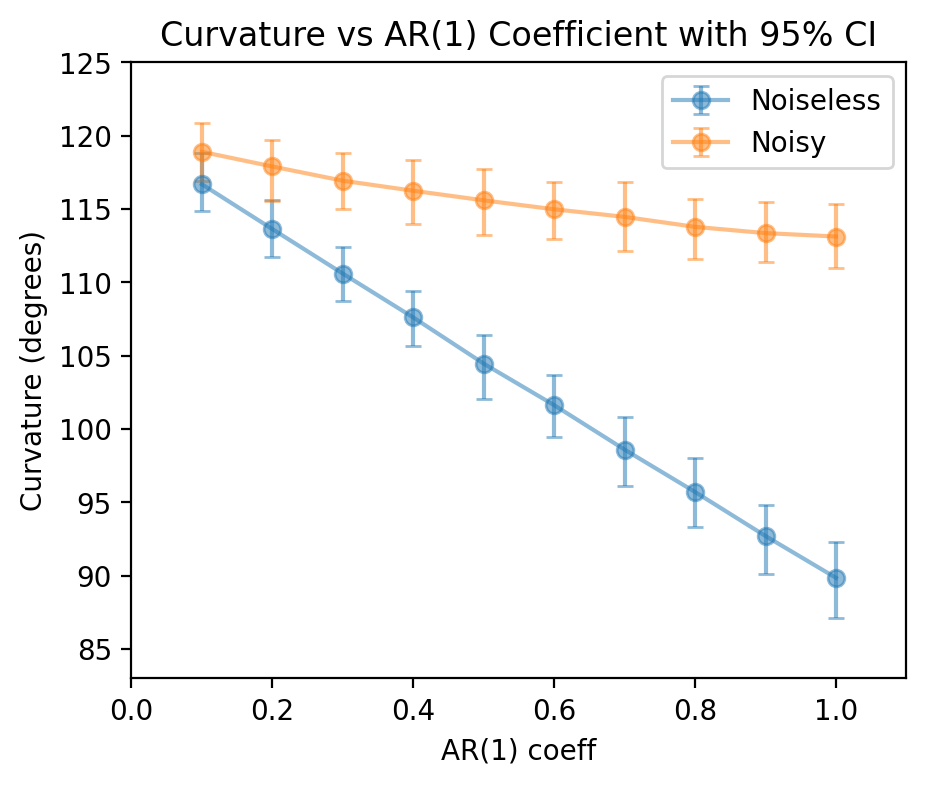

Noiseless mean curvature: [116.6942219  113.638899   110.60325949 107.61364077 104.46438534
 101.63285902  98.60128414  95.71438565  92.71115429  89.86080956] shape:  (10,)
Noisy mean curvature: [118.90808316 117.90619903 116.93703617 116.25164987 115.59782871
 114.98805127 114.47047224 113.78975318 113.3640252  113.13101218] shape:  (10,)


In [39]:
# Compute mean and 95% CI across bootstraps
noiseless_mean_curv = noiseless_est_curv.mean(axis=0)             
noiseless_lower = np.percentile(noiseless_est_curv, 2.5, axis=0)   
noiseless_upper = np.percentile(noiseless_est_curv, 97.5, axis=0) # shape: len(ar_coeffs)

noisy_mean_curv = noisy_est_curv.mean(axis=0)             
noisy_lower = np.percentile(noisy_est_curv, 2.5, axis=0)   
noisy_upper = np.percentile(noisy_est_curv, 97.5, axis=0) # shape: len(ar_coeffs)

# Compute error bars: distance from mean to lower/upper CI
noiseless_yerr = np.vstack([noiseless_mean_curv - noiseless_lower, noiseless_upper - noiseless_mean_curv])
noisy_yerr = np.vstack([noisy_mean_curv - noisy_lower, noisy_upper - noisy_mean_curv])

# Plot with error bars
plt.errorbar(ar_coeffs, noiseless_mean_curv, yerr=noiseless_yerr, fmt='o-', capsize=3, label='Noiseless',alpha = 0.5)
plt.errorbar(ar_coeffs, noisy_mean_curv, yerr=noisy_yerr, fmt='o-', capsize=3, label='Noisy', alpha = 0.5)

plt.xlim(0, 1.1)
plt.ylim(83, 125)
plt.xlabel("AR(1) coeff")
plt.ylabel("Curvature (degrees)")
plt.title("Curvature vs AR(1) Coefficient with 95% CI")
plt.legend()
plt.show()

print("Noiseless mean curvature:", noiseless_mean_curv, "shape: ", noiseless_mean_curv.shape) # direct noiseless/ground truth 
print("Noisy mean curvature:", noisy_mean_curv, "shape: ", noisy_mean_curv.shape) # direct white noise 


Plotting with specified format for illustrator (pdf)

In [154]:
fig, ax = plt.subplots(figsize=(5, 4))  

ax.errorbar(
    ar_coeffs, noiseless_mean_curv, yerr=noiseless_yerr,
    fmt='o-', markersize=15, linewidth=2, elinewidth=2, capsize=0,
    label='Noiseless', alpha=1, color='black'
)
ax.errorbar(
    ar_coeffs, noisy_mean_curv, yerr=noisy_yerr,
    fmt='o-', markersize=15, linewidth=2, elinewidth=2, capsize=0,
    label='Noisy', alpha=1, color=(0.5, 0.5, 0.5)
)

ax.set_xlim(0, 1.1)
ax.set_ylim(83, 125)
ax.set_yticks([90, 120])
ax.set_xlabel("AR(1) coeff", fontsize=4, labelpad=1)
ax.set_ylabel("Curvature (°)", fontsize=4, labelpad=1)
ax.tick_params(axis='both', labelsize=3, pad=1)

for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout(pad=0.1)

plt.savefig("curv-AR_0.5noisy_noiseless_CI.pdf", format='pdf', bbox_inches='tight') 
plt.close()

Plotting ground truth curvature vs. estimated curvature

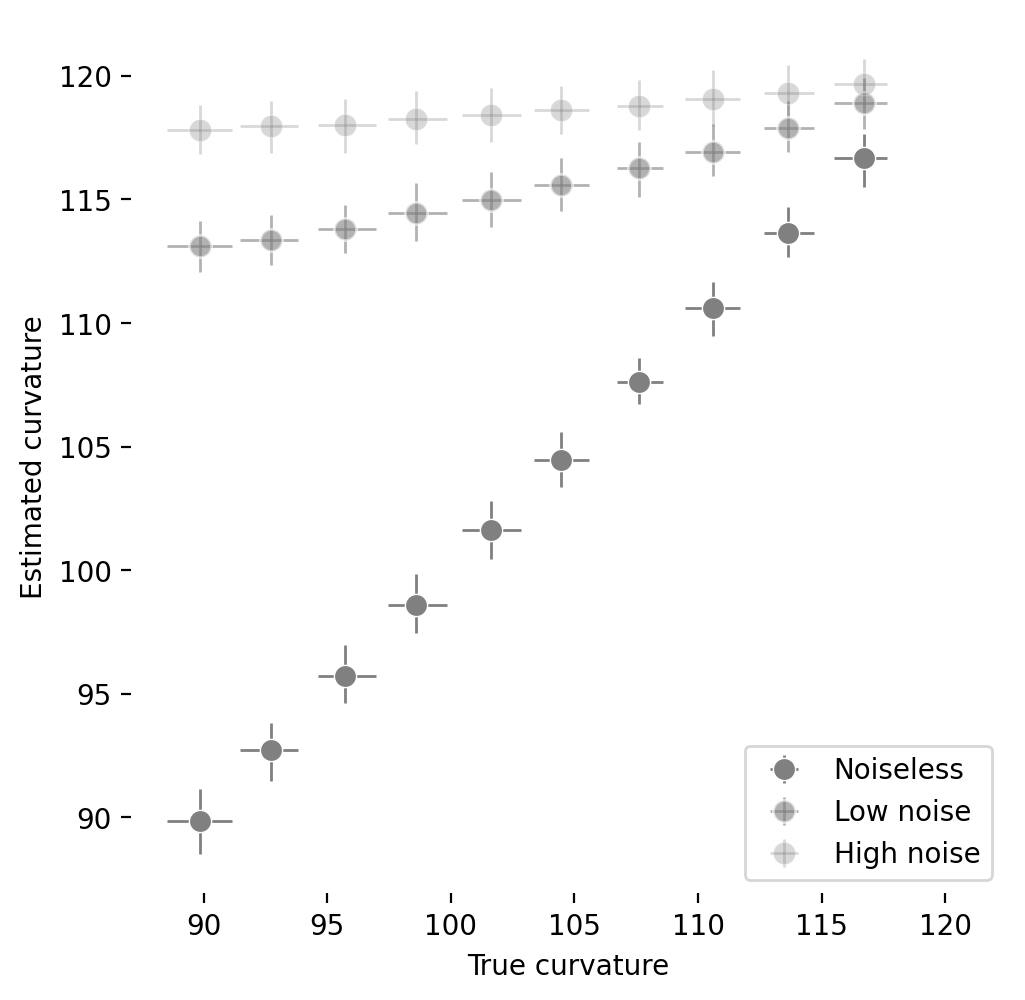

In [40]:
noiseless_mean_curv = noiseless_est_curv.mean(axis=0)
noisy_mean_curv     = noisy_est_curv.mean(axis=0)
high_noisy_mean_curv = high_noisy_est_curv.mean(axis=0)

def bootstrap_ci(data):
    lower = np.percentile(data, 16, axis=0)
    upper = np.percentile(data, 84, axis=0)
    mean  = data.mean(axis=0)
    return mean, [mean - lower, upper - mean]

noiseless_mean, noiseless_ci = bootstrap_ci(noiseless_est_curv)
noisy_mean, noisy_ci = bootstrap_ci(noisy_est_curv)
high_noisy_mean, high_noisy_ci = bootstrap_ci(high_noisy_est_curv)

# ---- Plot ----
axis_stroke    = 0.5  * 72    # 36 pt
axis_height    = 0.85 * 72    # 61.2 pt
fig, ax = plt.subplots(figsize=(5, 5))

# NOISELESS (darkest gray)
ax.errorbar(
    noiseless_mean,
    noiseless_mean,
    xerr=noiseless_ci,
    yerr=noiseless_ci,
    fmt='o',
    markersize=8,
    markerfacecolor='gray',
    markeredgecolor='white',
    markeredgewidth=0.5,
    linewidth=1,
    color='gray',
    alpha=1.0,
    label="Noiseless"
)

# LOW NOISE (medium opacity)
ax.errorbar(
    noiseless_mean,
    noisy_mean,
    xerr=noiseless_ci,
    yerr=noisy_ci,
    fmt='o',
    markersize=8,
    markerfacecolor='gray',
    markeredgecolor='white',
    markeredgewidth=1,
    linewidth=1,
    color='gray',
    alpha=0.6,
    label="Low noise"
)

# HIGH NOISE (lightest opacity)
ax.errorbar(
    noiseless_mean,
    high_noisy_mean,
    xerr=noiseless_ci,
    yerr=high_noisy_ci,
    fmt='o',
    markersize=8,
    markerfacecolor='gray',
    markeredgecolor='white',
    markeredgewidth=0.5,
    linewidth=1,
    color='gray',
    alpha=0.3,
    label="High noise"
)

# ---- Axes ----
ax.set_xlabel("True curvature")
ax.set_ylabel("Estimated curvature")

# Square and equal limits
ax.set_aspect('equal', adjustable='datalim')
ax.axis('square')

# ---- Spines thickness ----
for spine in ax.spines.values():
    spine.set_visible(False)

# Emphasize vertical spines (your requested axis_height)
ax.spines['left'].set_linewidth(axis_height)
ax.spines['right'].set_linewidth(axis_height)

ax.legend()

plt.tight_layout(pad=0.3)
plt.savefig("single_trial_GTcurv-curv_diffnoise_CI.pdf", format='pdf', bbox_inches='tight')
plt.show()


In [5]:
# ---- MINI-FIGURE SETTINGS (everything shrunk proportionally) ----
figsize_inches = (0.5, 0.5)

marker_size     = 1      
marker_edge     = 0.1     
line_width      = 0.4     
font_size       = 4       
alpha_noiseless = 1.0
alpha_low       = 0.6
alpha_high      = 0.3

# ---- Create tiny figure ----
fig, ax = plt.subplots(figsize=figsize_inches, dpi=300)

# ---- Noiseless ----
ax.errorbar(
    noiseless_mean, noiseless_mean,
    xerr=noiseless_ci, yerr=noiseless_ci,
    fmt='o',
    markersize=marker_size,
    markerfacecolor='gray',
    markeredgecolor='white',
    markeredgewidth=marker_edge,
    linewidth=line_width,
    color='gray',
    alpha=alpha_noiseless
)


# ---- Low noise ----
ax.errorbar(
    noiseless_mean, noisy_mean,
    xerr=noiseless_ci, yerr=noisy_ci,
    fmt='o',
    markersize=marker_size,
    markerfacecolor='gray',
    markeredgecolor='white',
    markeredgewidth=marker_edge,
    linewidth=line_width,
    color='gray',
    alpha=alpha_low
)

# ---- High noise ----
ax.errorbar(
    noiseless_mean, high_noisy_mean,
    xerr=noiseless_ci, yerr=high_noisy_ci,
    fmt='o',
    markersize=marker_size,
    markerfacecolor='gray',
    markeredgecolor='white',
    markeredgewidth=marker_edge,
    linewidth=line_width,
    color='gray',
    alpha=alpha_high
)


ax.tick_params(labelsize=font_size - 1, length=1, width=0.25)
ax.set_xticks([90, 120])
ax.set_yticks([90, 120])
ax.set_aspect('equal', adjustable='datalim')
ax.axis('square')

# Remove all spines (no box)
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout(pad=0.05)
plt.savefig("single_trial_GTcurv-curv_diffnoise_CI_tiny.pdf", format='pdf', bbox_inches='tight')
plt.close()


##### Fig 2a-b Estimate AR(1) coefficient as an indirect proxy for curvature 

In [41]:
# recover AR coefficients (from 10-D data - approximates averaging across 10 runs for a single voxel)
noiseless_ar_coeff = np.zeros((nBoots,len(ar_coeffs)))  
noisy_ar_coeff = np.zeros((nBoots,len(ar_coeffs)))  
rec_noiseless_timeseries = np.zeros((nBoots, len(ar_coeffs), n_voxs, nT))
rec_noisy_timeseries = np.zeros((nBoots, len(ar_coeffs), n_voxs, nT))
rec_noiseless_est_curv = np.zeros((nBoots, len(ar_coeffs)))
rec_noisy_est_curv = np.zeros((nBoots, len(ar_coeffs)))

avg_noiseless_timeseries = noiseless_timeseries


for boot in range(nBoots):
        for a in range(len(ar_coeffs)):
        # --- noiseless ---
                # estimate ar coeff
                avg_vox_noiseless_ts = np.mean(avg_noiseless_timeseries[boot,a], axis=0)
                zs_avg_noiseless_ts = zs(avg_vox_noiseless_ts)
                noiseless_ar1_model = sm.tsa.AutoReg(zs_avg_noiseless_ts, lags=1).fit()
                noiseless_ar_coeff[boot, a] = noiseless_ar1_model.params[1]
                # use recovered AR coeff to simulate new timeseries 
                private_signal_innov = np.random.randn(n_voxs, nT) * private_signal_std
                rec_noiseless_timeseries[boot, a, :, :] = make_noiseless_arp(ar_coeff=noiseless_ar1_model.params[1], 
                                                                               nT=nT, 
                                                                               n_voxs=n_voxs,
                                                                               private_signal_innov=private_signal_innov)
                # calculate curvature (Avg GT)
                rec_noiseless_est_curv[boot, a] = avg_pop_curvature(rec_noiseless_timeseries[boot, a, :, :])

        # --- noisy (high) ---
                # estimate ar coeff
                avg_vox_noisy_ts = np.mean(avg_noisy_timeseries[boot,a], axis=0)
                zs_avg_noisy_ts = zs(avg_vox_noisy_ts)
                noisy_ar1_model = sm.tsa.AutoReg(zs_avg_noisy_ts, lags=1).fit()
                noisy_ar_coeff[boot, a] = noisy_ar1_model.params[1]
                # use recovered AR coeff to simulate new timeseries 
                rec_noisy_timeseries[boot, a, :, :] = make_noiseless_arp(ar_coeff=noisy_ar1_model.params[1], 
                                                                           nT=nT, 
                                                                           n_voxs=n_voxs,
                                                                           private_signal_innov=private_signal_innov)
                # calculate curvature 
                rec_noisy_est_curv[boot, a] = avg_pop_curvature(rec_noisy_timeseries[boot, a, :, :])

        

Plot ground truth AR(1) coeff vs. estimated AR(1) coeff

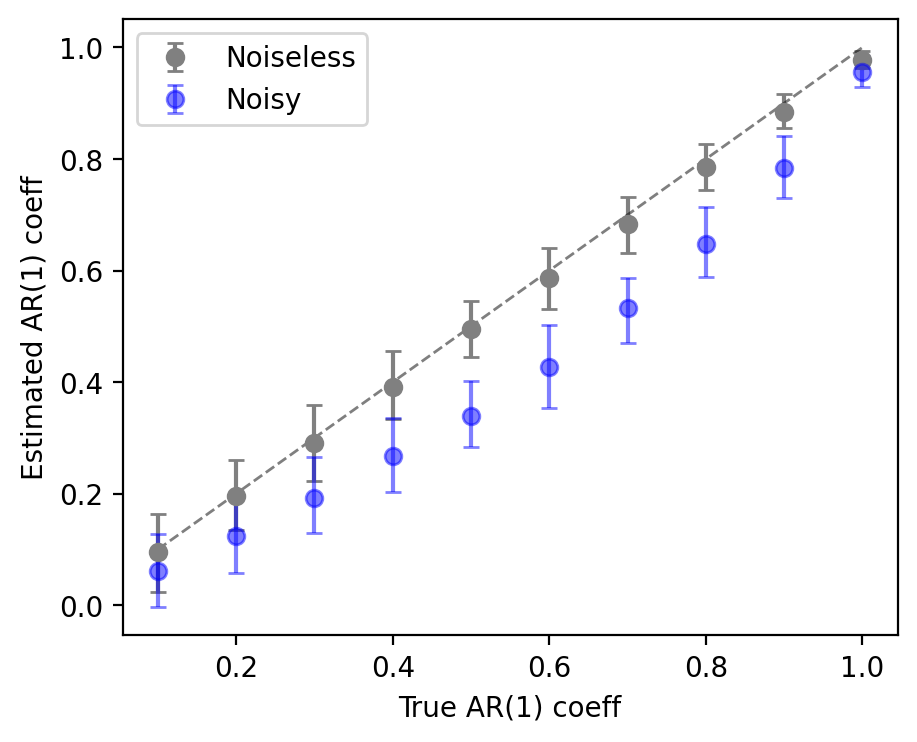

In [42]:
# Compute means
noiseless_mean_ar = noiseless_ar_coeff.mean(axis=0)
noisy_mean_ar = noisy_ar_coeff.mean(axis=0)

# Compute 95% bootstrap percentile confidence intervals (asymmetric)
noiseless_lower = np.percentile(noiseless_ar_coeff, 16, axis=0)
noiseless_upper = np.percentile(noiseless_ar_coeff, 84, axis=0)
noiseless_ci = [noiseless_mean_ar - noiseless_lower, noiseless_upper - noiseless_mean_ar]
noisy_lower = np.percentile(noisy_ar_coeff, 16, axis=0)
noisy_upper = np.percentile(noisy_ar_coeff, 84, axis=0)
noisy_ci = [noisy_mean_ar - noisy_lower, noisy_upper - noisy_mean_ar]

# Plot
plt.errorbar(ar_coeffs, noiseless_mean_ar, yerr=noiseless_ci, fmt='o', label='Noiseless', alpha=1, capsize=3, color='gray')
plt.errorbar(ar_coeffs, noisy_mean_ar, yerr=noisy_ci, fmt='o', label='Noisy', alpha=0.5, capsize=3, color='blue')
plt.plot(ar_coeffs, ar_coeffs, 'k--', linewidth=1, alpha=0.5)  # y = x reference line
plt.xlabel("True AR(1) coeff")      
plt.ylabel("Estimated AR(1) coeff")
plt.legend()
# plt.savefig("recovered_ar1_coeffs_bootstrap.pdf", format='pdf', bbox_inches='tight')

# print("Noiseless recovered AR coeffs:", noiseless_mean_ar, "shape: ", noiseless_mean_ar.shape) # indirect noiseless
# print("Noisy recovered AR coeffs:", noisy_mean_ar, "shape: ", noisy_mean_ar.shape) # indirect white noise



Pdf tiny figure

In [26]:
# Save the plot as pdf with specified figure size (for illustrator)
figsize_inches = (1, 1)

marker_size     = 1      
marker_edge     = 0.1     
line_width      = 0.3     
font_size       = 4       
alpha_noiseless = 1.0
alpha_low       = 0.6
alpha_high      = 0.3

# ---- Create tiny figure ----
fig, ax = plt.subplots(figsize=figsize_inches, dpi=300)
ax.errorbar(ar_coeffs, noiseless_mean_ar, yerr=noiseless_ci, fmt='o', markersize=marker_size, linewidth=line_width, capsize=0.2,
    label='Noiseless', alpha=1, color='black')

ax.errorbar(ar_coeffs, noisy_mean_ar, yerr=noisy_ci, fmt='o', markersize=marker_size, linewidth=line_width, capsize=0.2,
    label='Noisy', alpha=0.7, color='grey')

# y = x reference line
ax.plot(ar_coeffs, ar_coeffs, 'k--', linewidth=0.2, alpha=1, color='black')

# Labels and formatting
# ax.set_xlabel("True AR(1) coeff", fontsize=3)
# ax.set_ylabel("Est AR(1) coeff", fontsize=3)
ax.tick_params(axis='both',
               which='both',
               labelsize=3,   # font size of tick labels
               length=2,      # length of tick marks
               width=0.5)       # line width of tick marksax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_aspect('equal')
ax.legend(loc='upper left', fontsize=2, frameon=False)
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.savefig("recovered_ar1_coeffs_bootstrap_tiny.pdf", format='pdf', bbox_inches='tight')
plt.close()

/var/folders/gq/_9ggz_gd2y57qgdgg8jsdz0r0000gp/T/ipykernel_92299/254626161.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(ar_coeffs, ar_coeffs, 'k--', linewidth=0.2, alpha=1, color='black')


Calculate the curvature estimation errors for different methods

In [44]:
# direct noiseless
dir_noiseless = noiseless_mean_curv - noiseless_mean_curv
# direct noisy
dir_noisy_est = noisy_est_curv - noiseless_mean_curv
dir_noisy_mean = dir_noisy_est.mean(axis=0)
# Compute 95% bootstrap percentile confidence intervals (asymmetric)
dir_noisy_lower = np.percentile(dir_noisy_est, 16, axis=0)
dir_noisy_upper = np.percentile(dir_noisy_est, 84, axis=0)
ci = [dir_noisy_mean - dir_noisy_lower, dir_noisy_upper - dir_noisy_mean]

# indirect noiseless
indirect_noiseless_est = rec_noiseless_est_curv - noiseless_mean_curv
ind_noiseless_mean = indirect_noiseless_est.mean(axis=0)
ind_noiseless_lower = np.percentile(indirect_noiseless_est, 16, axis=0)
ind_noiseless_upper = np.percentile(indirect_noiseless_est, 84, axis=0)
ind_noiseless_ci = [ind_noiseless_mean - ind_noiseless_lower,
                    ind_noiseless_upper - ind_noiseless_mean]

# Indirect noisy 
indirect_noisy_est = rec_noisy_est_curv - noiseless_mean_curv
ind_noisy_mean = indirect_noisy_est.mean(axis=0)
ind_noisy_lower = np.percentile(indirect_noisy_est, 16, axis=0)
ind_noisy_upper = np.percentile(indirect_noisy_est, 84, axis=0)
ind_noisy_ci = [ind_noisy_mean - ind_noisy_lower,
                ind_noisy_upper - ind_noisy_mean]




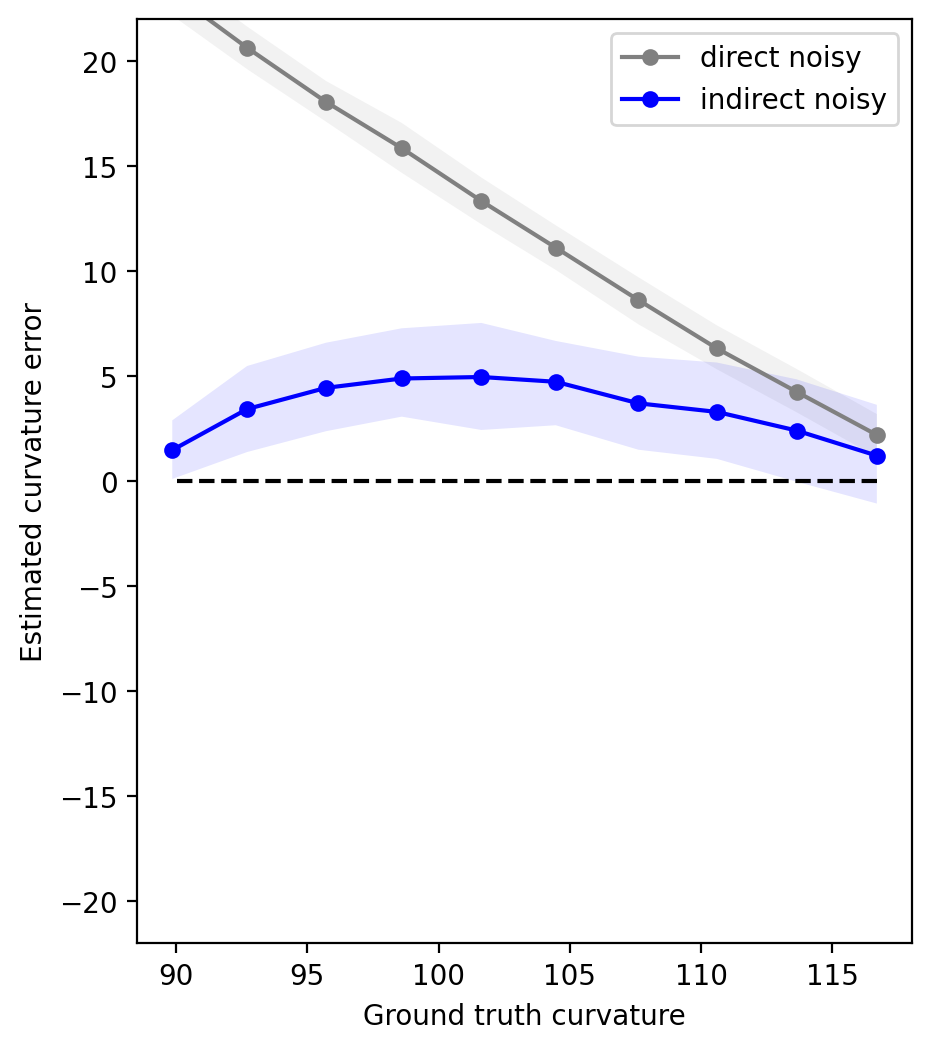

In [45]:
# plotting with error bars 
plt.figure(figsize=(5, 6))

# --- Ground truth line ---
# plt.plot(noiseless_mean_curv, dir_noiseless, 'o-', alpha=1, color='black', markersize=5)
plt.plot(noiseless_mean_curv, dir_noiseless,'--', color='black')

# --- Direct noisy ---
plt.plot(noiseless_mean_curv, dir_noisy_mean, 'o-', alpha=1, label='direct noisy', color='grey', markersize=5)
plt.fill_between(
    noiseless_mean_curv,
    dir_noisy_mean - ci[0],
    dir_noisy_mean + ci[1],
    color='grey', alpha=0.1,
    edgecolor='none',
    linewidth=0
)

# --- Indirect noiseless ---
# plt.plot(noiseless_mean_curv, ind_noiseless_mean, 'o-', alpha=1, label='indirect noiseless', color='blue', markersize=5)
# plt.fill_between(
#     noiseless_mean_curv,
#     ind_noiseless_mean - ind_noiseless_ci[0],
#     ind_noiseless_mean + ind_noiseless_ci[1],
#     color='blue', alpha=0.1,
#     edgecolor='none', linewidth=0
# )

# --- Indirect noisy ---
plt.plot(noiseless_mean_curv, ind_noisy_mean, 'o-', alpha=1, label='indirect noisy', color='blue', markersize=5)
plt.fill_between(
    noiseless_mean_curv,
    ind_noisy_mean - ind_noisy_ci[0],
    ind_noisy_mean + ind_noisy_ci[1],
    color='blue', alpha=0.1,
    edgecolor='none',
    linewidth=0
)

plt.legend()
plt.ylim(-22, 22)
plt.xlabel("Ground truth curvature")
plt.ylabel("Estimated curvature error")
plt.savefig("curv_est_error_noisy.pdf", format='pdf', bbox_inches='tight')
plt.show()


Plotting with specified format for illustrator (pdf)

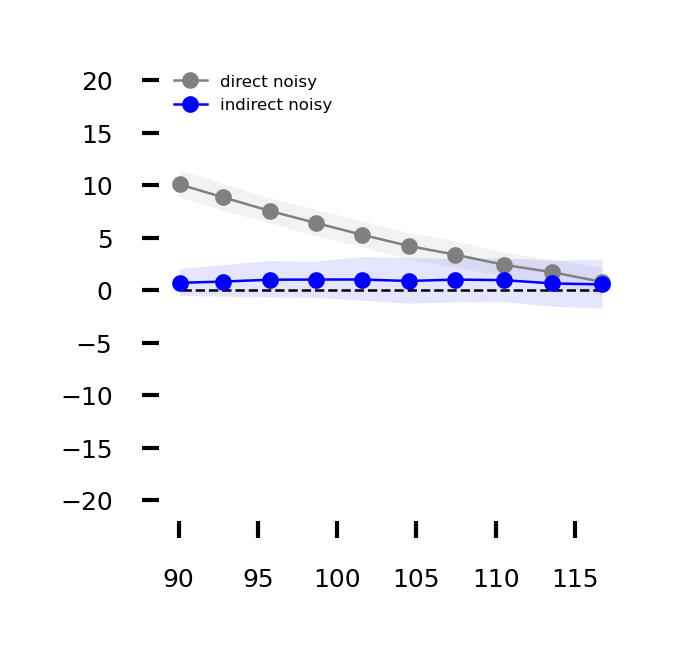

In [152]:
figsize_inches = (1, 1)

marker_size     = 1      
marker_edge     = 0.1     
line_width      = 0.3     
font_size       = 4       
alpha_noiseless = 1.0
alpha_low       = 0.6
alpha_high      = 0.3

fig, ax = plt.subplots(figsize=figsize_inches, dpi=300)

# --- Ground truth line ---
# plt.plot(noiseless_mean_curv, dir_noiseless, 'o-', alpha=1, color='black', markersize=5)
plt.plot(noiseless_mean_curv, dir_noiseless,'--', color='black', linewidth=line_width)

# --- Direct noisy ---
plt.plot(noiseless_mean_curv, dir_noisy_mean, 'o-', alpha=1, label='direct noisy', color='grey', markersize=marker_size, linewidth=line_width)
plt.fill_between(
    noiseless_mean_curv,
    dir_noisy_mean - ci[0],
    dir_noisy_mean + ci[1],
    color='grey', alpha=0.1,
    edgecolor='none',
    linewidth=0
)

# --- Indirect noiseless ---
# plt.plot(noiseless_mean_curv, ind_noiseless_mean, 'o-', alpha=1, label='indirect noiseless', color='blue', markersize=5)
# plt.fill_between(
#     noiseless_mean_curv,
#     ind_noiseless_mean - ind_noiseless_ci[0],
#     ind_noiseless_mean + ind_noiseless_ci[1],
#     color='blue', alpha=0.1
# )

# --- Indirect noisy ---
plt.plot(noiseless_mean_curv, ind_noisy_mean, 'o-', alpha=1, label='indirect noisy', color='blue', markersize=marker_size, linewidth=line_width)
plt.fill_between(
    noiseless_mean_curv,
    ind_noisy_mean - ind_noisy_ci[0],
    ind_noisy_mean + ind_noisy_ci[1],
    color='blue', alpha=0.1,
    edgecolor='none',
    linewidth=0
)

ax.legend(loc='upper left', fontsize=2, frameon=False)
for spine in ax.spines.values():
    spine.set_visible(False)

ax.tick_params(axis='both',
               which='both',
               labelsize=3,   # font size of tick labels
               length=2,      # length of tick marks
               width=0.5)       # line width of tick marksax.set_xlim(-0.1, 1.1)

plt.ylim(-22, 22)
# plt.xlabel("Ground truth curvature")
# plt.ylabel("Estimated curvature error")
plt.savefig("curv_est_error_noisy_tiny.pdf", format='pdf', bbox_inches='tight')
plt.show()
